## Visual for results （expriments） joints application--section3.4

### Input sequence [4,2500,16]--represent the pressure in the test
### the joint application need to get the aoa by inverse model and let the aoa input the forward model
### Output sequence [4,2500,3]--represent the force in the test

In [182]:
import torch
import os
import sys

In [183]:
directory_path = os.path.dirname(os.getcwd())
# Optionally, print all paths to confirm the addition
for path in sys.path:
    print("Import path:", path)

Import path: /root/autodl-tmp/Gust
Import path: /root/autodl-tmp/Gust
Import path: /root/autodl-tmp/Gust
Import path: /root/autodl-tmp/Gust
Import path: /root/autodl-tmp/Gust
Import path: /root/autodl-tmp/Gust/Visual
Import path: /root/miniconda3/lib/python38.zip
Import path: /root/miniconda3/lib/python3.8
Import path: /root/miniconda3/lib/python3.8/lib-dynload
Import path: 
Import path: /root/miniconda3/lib/python3.8/site-packages
Import path: /root/workspace/rsl_rl
Import path: /root/swimmingdog_mujoco
Import path: /root/autodl-tmp/Gust/Models
Import path: /root/autodl-tmp/Gust/Models
Import path: /root/autodl-tmp/Gust/Models
Import path: /root/autodl-tmp/Gust/Models
Import path: /root/autodl-tmp/Gust/Models


In [184]:
sys.path.insert(0, "/root/autodl-tmp/Gust") #please add your path case by case linux or wins
# 添加 Models 文件夹路径到 sys.path
sys.path.append('/root/autodl-tmp/Gust/Models')

In [185]:
print(sys.path)

['/root/autodl-tmp/Gust', '/root/autodl-tmp/Gust', '/root/autodl-tmp/Gust', '/root/autodl-tmp/Gust', '/root/autodl-tmp/Gust', '/root/autodl-tmp/Gust', '/root/autodl-tmp/Gust/Visual', '/root/miniconda3/lib/python38.zip', '/root/miniconda3/lib/python3.8', '/root/miniconda3/lib/python3.8/lib-dynload', '', '/root/miniconda3/lib/python3.8/site-packages', '/root/workspace/rsl_rl', '/root/swimmingdog_mujoco', '/root/autodl-tmp/Gust/Models', '/root/autodl-tmp/Gust/Models', '/root/autodl-tmp/Gust/Models', '/root/autodl-tmp/Gust/Models', '/root/autodl-tmp/Gust/Models', '/root/autodl-tmp/Gust/Models']


### get inverse model

In [186]:
inverse_model = "/root/autodl-tmp/Gust/Checkpoints/expr3d_inverse/best_model.pth"
dataset_path = "/root/autodl-tmp/Gust/Dataset/Expriments/Expr_no_aug_sec_3_2.pt"

In [187]:
paras = torch.load(inverse_model)

### model paras
#### We recommend:
- **num_layers**: 4
- **nhead**: 4
- **input_dim**: 16
- **output_dim**: 3
- **d_model**: 20
- **num_sensors**: 16

In [188]:
from Models.GAT_Transformer import TransformerDecoder

In [189]:
yaml_path = "/root/autodl-tmp/Gust/Checkpoints/expr3d_inverse/config.yaml"

In [190]:
import yaml
# 打开并读取 YAML 文件
with open(yaml_path, 'r') as file:
    set_dict = yaml.safe_load(file)

In [191]:
inverse_model = TransformerDecoder(**set_dict["Model"]["details"])

In [192]:
inverse_model.load_state_dict(paras)

<All keys matched successfully>

In [193]:
# 切换到评估模式
inverse_model.eval()

TransformerDecoder(
  (embedding): Linear(in_features=16, out_features=48, bias=True)
  (layers): ModuleList(
    (0-3): 4 x TransformerDecoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=48, out_features=48, bias=True)
      )
      (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
      (graph_attn): GraphAttentionLayer(
        (gat): GATConv(48, 12, heads=4)
      )
      (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=49, out_features=192, bias=True)
        (1): ReLU()
        (2): Linear(in_features=192, out_features=48, bias=True)
      )
      (norm3): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
    )
  )
  (output_layer): Linear(in_features=48, out_features=1, bias=True)
)

In [194]:
test_dataset = torch.load(dataset_path)

In [195]:
from torch.utils.data import DataLoader

In [196]:
tensorset = test_dataset["test_dataset"]

In [197]:
test_loader = DataLoader(tensorset, batch_size = 30, shuffle=True)

### input for forward models

In [198]:
forward_model_path = "/root/autodl-tmp/Gust/Checkpoints/expr3d_forward/best_model.pth"
f_yaml = "/root/autodl-tmp/Gust/Checkpoints/expr3d_forward/config.yaml"

In [199]:
f_paras = torch.load(forward_model_path)

In [200]:

# 打开并读取 YAML 文件
with open(f_yaml, 'r') as file:
    f_set_dict = yaml.safe_load(file)


In [201]:
f_model = TransformerDecoder(**f_set_dict["Model"]["details"])
f_model.load_state_dict(f_paras)

<All keys matched successfully>

### plot results

In [202]:
for data,adj,aoa,truth in test_loader:
   adj = adj[0,:,:]
   # 获得反问题的aoa
   test_out_aoa = inverse_model(data,adj,None) #[4,2500,1]
   #reshape
 
   forward_aoa = test_out_aoa.permute(1,0,2)
   test_out = f_model(data,adj,forward_aoa)

In [203]:
import torch.nn as nn
# 创建 MSE 损失函数
mse_loss_fn = nn.MSELoss()

# 计算 MSE 损失
mse_loss = mse_loss_fn(test_out, truth)

# 打印 MSE 损失值
print("Test MSE Loss:", mse_loss.item())

Test MSE Loss: 0.004027767106890678


In [204]:
test_out = test_out.detach().numpy()

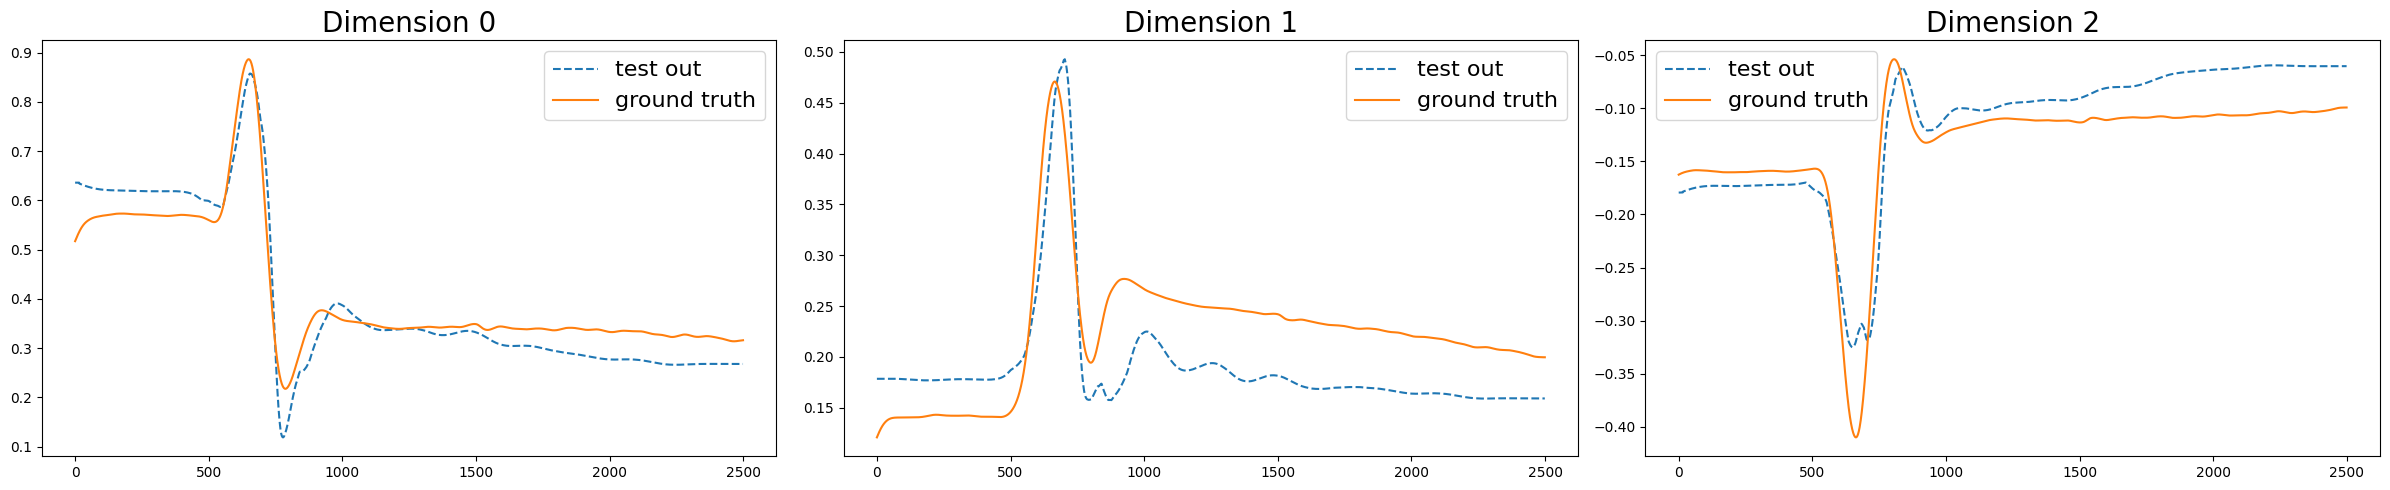

In [205]:
import matplotlib.pyplot as plt
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 5))

plt.rcParams['axes.titlesize'] = 20  # 设置标题字体大小
plt.rcParams['legend.fontsize'] = 16  # 设置图例字体大小
# Plot the first subplot (0th dimension)
axs[0].plot(test_out[0, :, 0], label="test out", linestyle="--")
axs[0].plot(truth[0, :, 0], label="ground truth")
axs[0].set_title("Dimension 0")
axs[0].legend()

# Plot the second subplot (1st dimension)
axs[1].plot(test_out[0, :, 1], label="test out", linestyle="--")
axs[1].plot(truth[0, :, 1], label="ground truth")
axs[1].set_title("Dimension 1")
axs[1].legend()

# Plot the third subplot (2nd dimension)
axs[2].plot(test_out[0, :, 2], label="test out", linestyle="--")
axs[2].plot(truth[0, :, 2], label="ground truth")
axs[2].set_title("Dimension 2")
axs[2].legend()

# Display the plots
plt.tight_layout()
plt.savefig("case1.png",dpi=300)

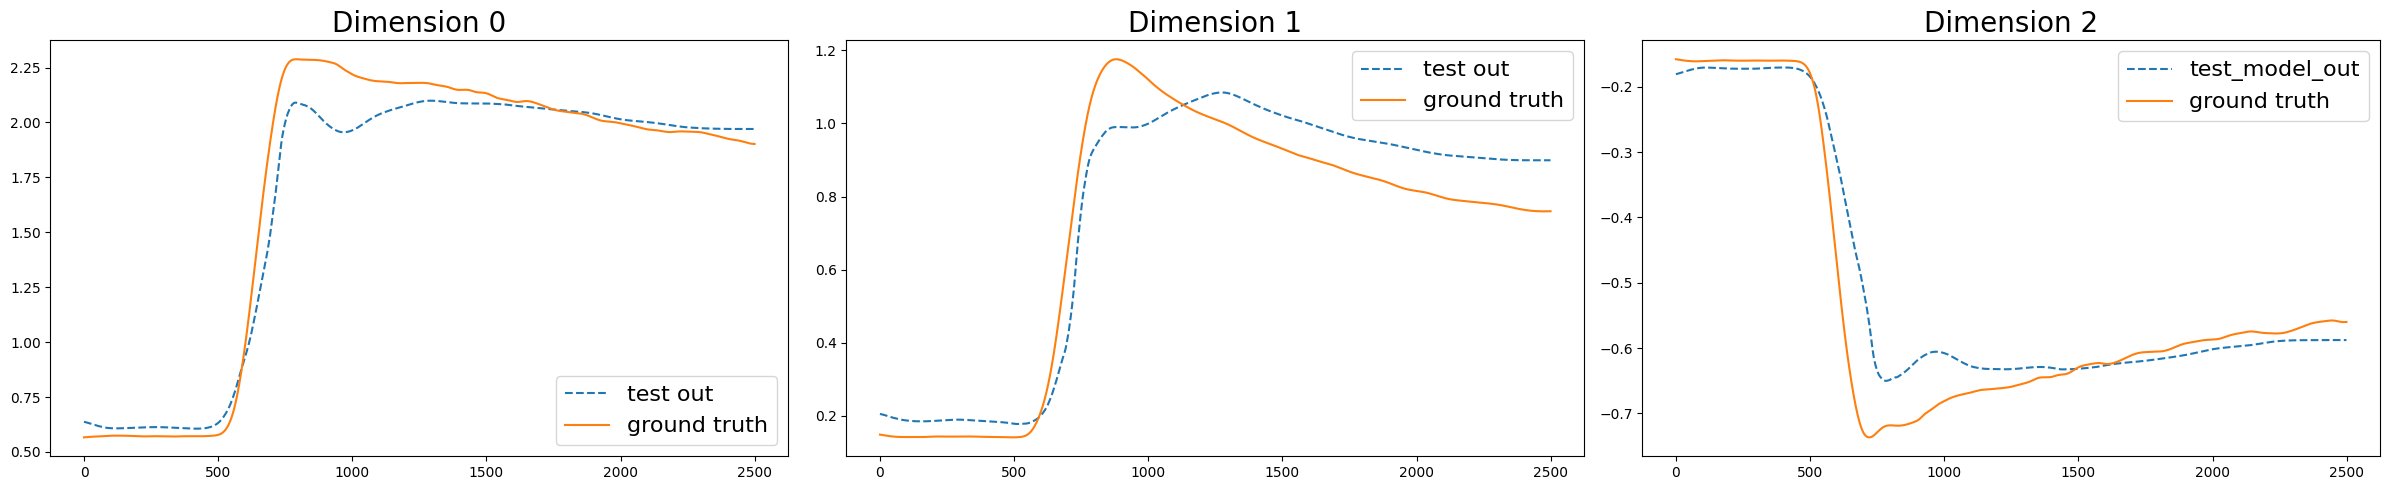

In [206]:
import matplotlib.pyplot as plt
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 5))

# Plot the first subplot (0th dimension)
axs[0].plot(test_out[1, :, 0], label="test out", linestyle="--")
axs[0].plot(truth[1, :, 0], label="ground truth")
axs[0].set_title("Dimension 0")
axs[0].legend()

# Plot the second subplot (1st dimension)
axs[1].plot(test_out[1, :, 1], label="test out", linestyle="--")
axs[1].plot(truth[1, :, 1], label="ground truth")
axs[1].set_title("Dimension 1")
axs[1].legend()

# Plot the third subplot (2nd dimension)
axs[2].plot(test_out[1, :, 2], label="test_model_out", linestyle="--")
axs[2].plot(truth[1, :, 2], label="ground truth")
axs[2].set_title("Dimension 2")
axs[2].legend()

# Display the plots
plt.tight_layout()
plt.savefig("case2.png",dpi=300)

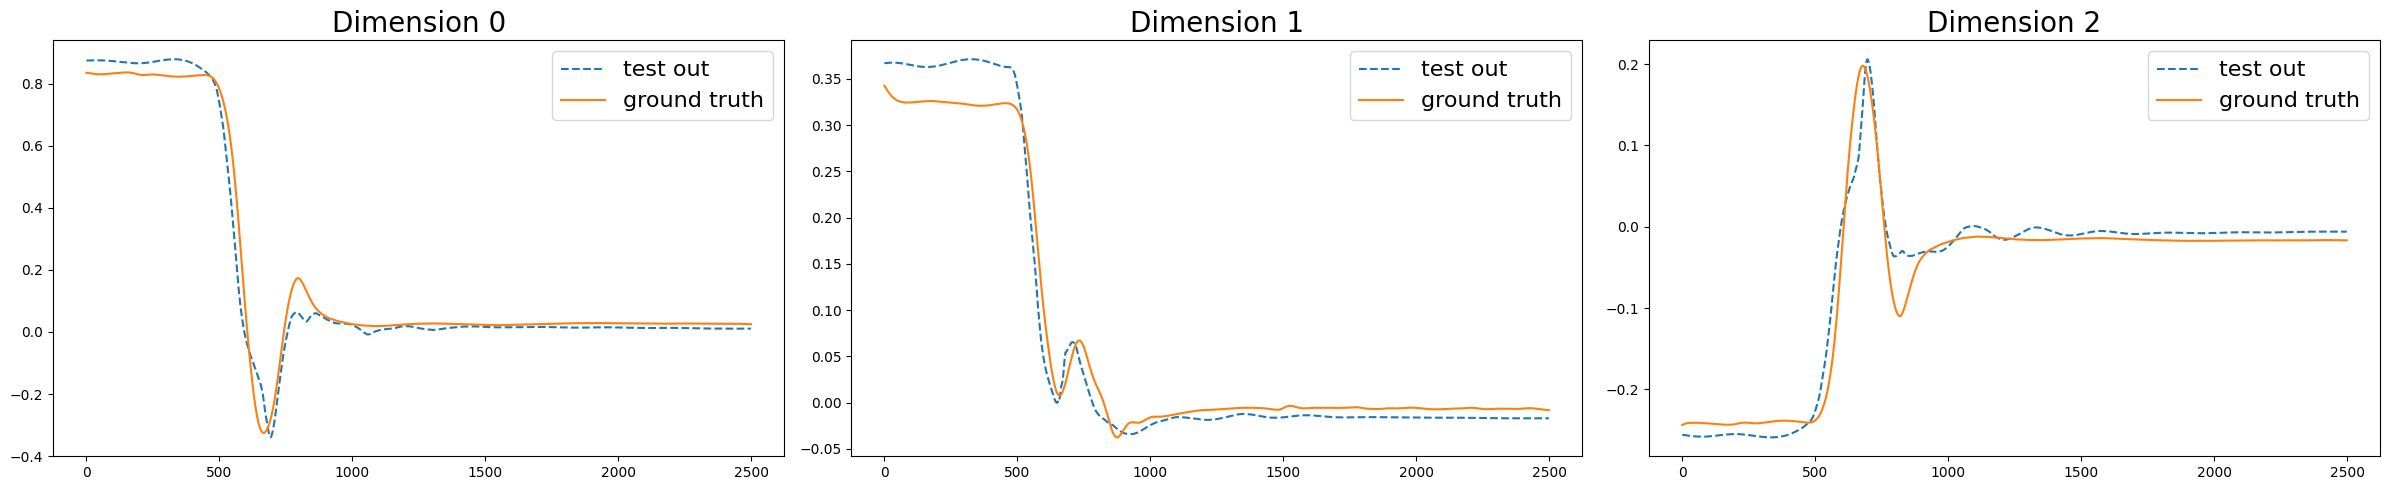

In [207]:
import matplotlib.pyplot as plt
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 5))

# Plot the first subplot (0th dimension)
axs[0].plot(test_out[2, :, 0], label="test out", linestyle="--")
axs[0].plot(truth[2, :, 0], label="ground truth")
axs[0].set_title("Dimension 0")
axs[0].legend()

# Plot the second subplot (1st dimension)
axs[1].plot(test_out[2, :, 1], label="test out", linestyle="--")
axs[1].plot(truth[2, :, 1], label="ground truth")
axs[1].set_title("Dimension 1")
axs[1].legend() 
# Plot the third subplot (2nd dimension)
axs[2].plot(test_out[2, :, 2], label="test out", linestyle="--")
axs[2].plot(truth[2, :, 2], label="ground truth")
axs[2].set_title("Dimension 2")
axs[2].legend()

# Display the plots
plt.tight_layout()
plt.savefig("case3.png",dpi=300)

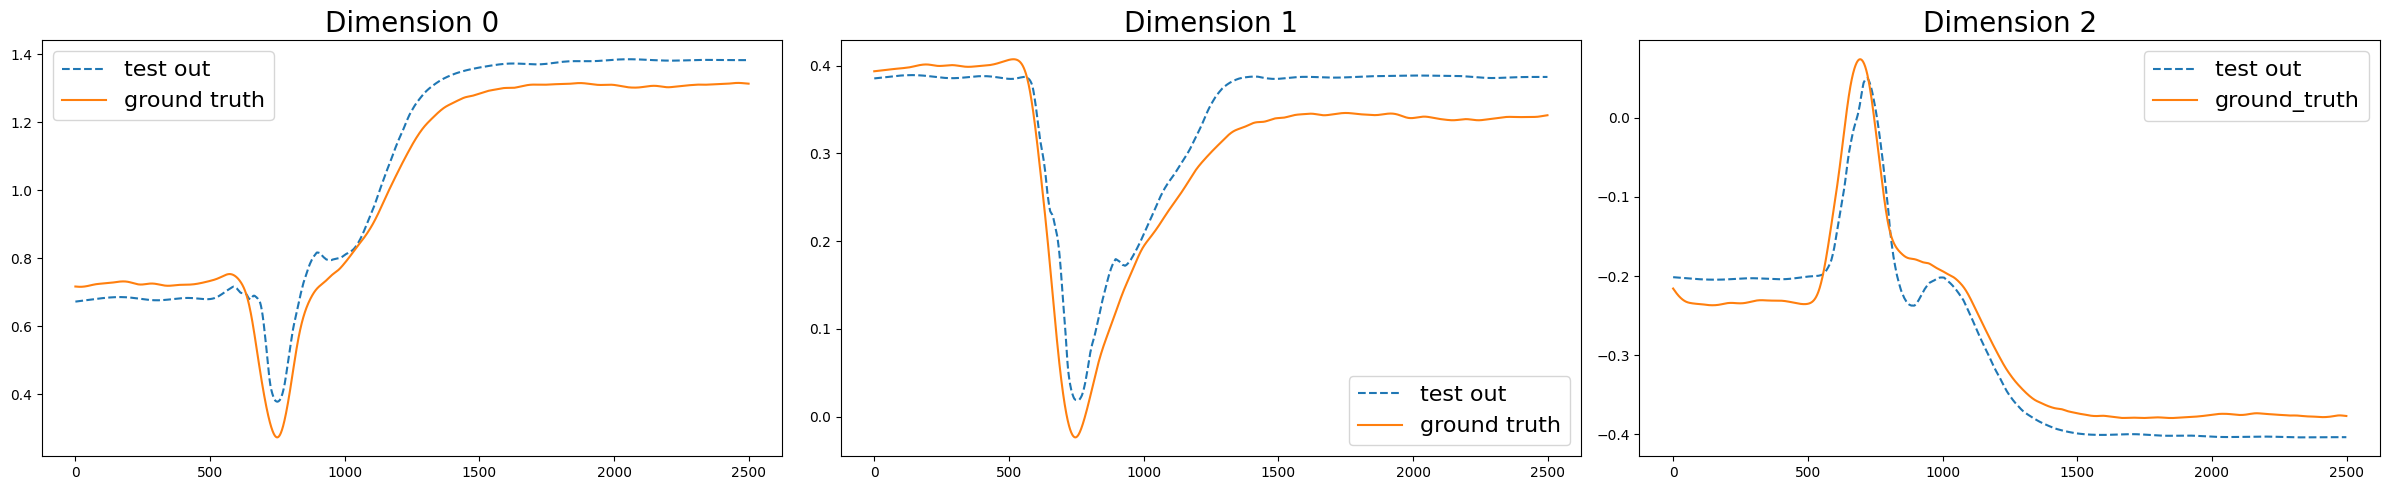

In [208]:
import matplotlib.pyplot as plt
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 5))

# Plot the first subplot (0th dimension)
axs[0].plot(test_out[3, :, 0], label="test out", linestyle="--")
axs[0].plot(truth[3, :, 0], label="ground truth")
axs[0].set_title("Dimension 0",fontsize=20)
axs[0].legend()

# Plot the second subplot (1st dimension)
axs[1].plot(test_out[3, :, 1], label="test out", linestyle="--")
axs[1].plot(truth[3, :, 1], label="ground truth")
axs[1].set_title("Dimension 1",fontsize=20)
axs[1].legend()

# Plot the third subplot (2nd dimension)
axs[2].plot(test_out[3, :, 2], label="test out", linestyle="--")
axs[2].plot(truth[3, :, 2], label="ground_truth")
axs[2].set_title("Dimension 2",fontsize=20)
axs[2].legend()

# Display the plots
plt.tight_layout()
plt.savefig("case4.png",dpi=300)

### plot attention heatmap

In [209]:
atten = f_model._get_layer_attention().detach().numpy()

torch.Size([4, 2500, 2500])


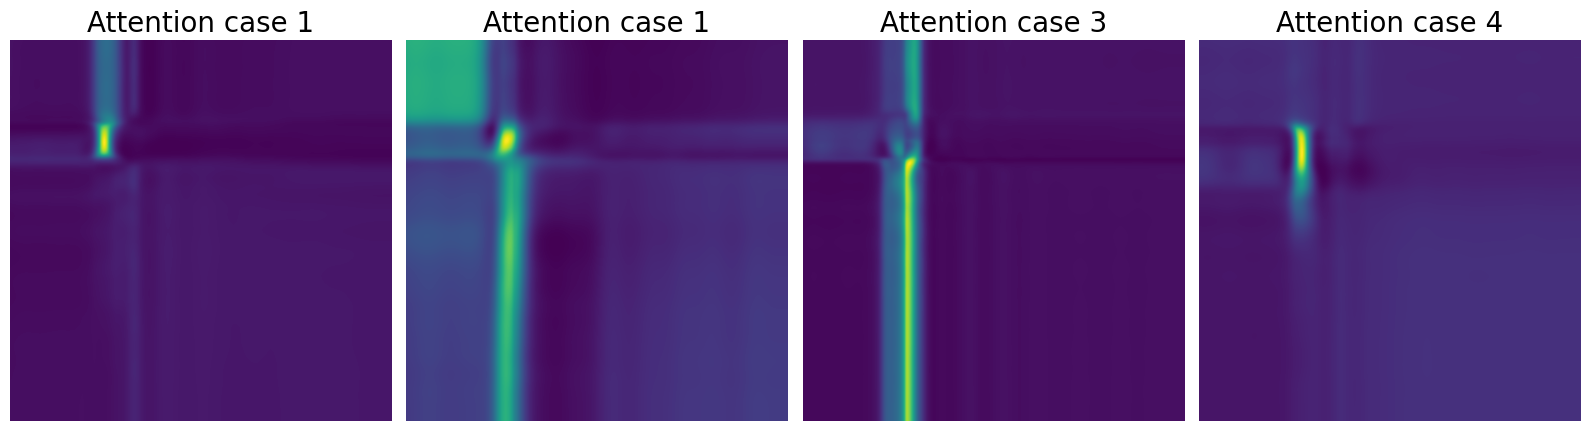

In [211]:
import matplotlib.pyplot as plt

# Assuming atten is a tensor or numpy array with shape [batch, height, width, channels] or [batch, channels, height, width]

# Create a figure and 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(16, 8))

# Plot the first subplot (attention 0)
axs[0].imshow(atten[0, :, :], cmap='viridis')
axs[0].set_title("Attention case 1")

# Plot the second subplot (attention 1)
axs[1].imshow(atten[1, :, :], cmap='viridis')
axs[1].set_title("Attention case 1")

# Plot the third subplot (attention 2)
axs[2].imshow(atten[2, :, :], cmap='viridis')
axs[2].set_title("Attention case 3")

# Plot the fourth subplot (attention 3)
axs[3].imshow(atten[3, :, :], cmap='viridis')
axs[3].set_title("Attention case 4")

for ax in axs:
   ax.axis('off')  # Hide x and y labels, ticks, and the axis

# Display the plots
plt.tight_layout()
plt.savefig("Joint aten.png",dpi=300,bbox_inches="tight")
